# Get, process and plot socioeconomic variables of SSPs

In [1]:
import io
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import pyam
import requests
from common import load_font, colors, set_plot_style

In [26]:
# consider SSP data from this year on
ssp_start_year = 2015

In [4]:
pyam.iiasa.platforms()
pyam.iiasa.Connection().valid_connections

[INFO] 16:09:27 - ixmp4.conf.auth: Connecting to service anonymously and without credentials.



Platforms accessible via 'https://api.manager.ece.iiasa.ac.at/v1'

Name                Access    Notice
public-test         public    This is a public ixmp4 test instance hosted by the IIA... 
ecemf               public    This is the public database instance for the Horizon 2... 
ssp-extensions      public    This is the SSP-Extensions project database. All data ... 
ssp                 public    This platform has the "basic drivers", i.e., GDP and p... 
socdr               public    This platform contains the data for the "State of CDR ... 
shape               public    This database has key scenarios developed by the SHAPE... 
navigate            public    This platform contains the data for the "NAVIGATE" Sce... 
genie               public    GENIE Knowledge Hubs                                      
elevate             public    This is the public database instance for the Horizon E... 
playground-publi... public    
ariadne2            public    This is the public database insta

[INFO] 16:09:28 - pyam.iiasa: You are connected as an anonymous user
[WARNING] 16:09:28 - pyam.iiasa: IIASA is migrating to a database infrastructure using the ixmp4 package.Use `pyam.iiasa.platforms()` to list available ixmp4 databases.


['ngfs_phase_3',
 'iamc15',
 'openentrance',
 'nexus_basins',
 'integration-test',
 'cdlinks',
 'india_scenario_hub',
 'genie',
 'hotspots',
 'ngfs_phase_4',
 'commit',
 'kopernikus_public',
 'senses',
 'aqnea',
 'navigate',
 'climate_solutions',
 'eu-climate-advisory-board',
 'engage',
 'nca5',
 'ngfs_phase_5_short_term',
 'ar6-public',
 'deeds',
 'ngfs_phase_5',
 'ngfs_phase_2',
 'gei',
 'netzero2040',
 'ripples',
 'ssp',
 'set_nav',
 'ariadne',
 'paris_lttg']

## Population & GPD projections from IIASA

In [27]:
connection_name = "ssp"
conn = pyam.iiasa.Connection(connection_name)

[INFO] 16:11:53 - pyam.iiasa: You are connected to the IXSE_SSP scenario explorer hosted by IIASA. If you use this data in any published format, please cite the data as provided in the explorer guidelines: https://data.ece.iiasa.ac.at/ssp/#/about
[INFO] 16:11:53 - pyam.iiasa: You are connected as an anonymous user


In [6]:
print(
    conn.models(),  # IIASA-WiC POP 2023 & IIASA GDP 2023
    conn.variables(),  # GDP|PPP & GDP|PPP [per capita] & Population
    conn.scenarios(),
    conn.regions(),  # world
    conn.properties(),
    sep="\n",
)

0       IIASA-WiC POP 2023
1     OECD ENV-Growth 2023
2    CDM Urbanization 2024
3           IIASA GDP 2023
Name: model, dtype: object
0                                                GDP|PPP
1                                   GDP|PPP [per capita]
2                Mean Years of Education|Female|Age 100+
3               Mean Years of Education|Female|Age 15-19
4               Mean Years of Education|Female|Age 20-24
                             ...                        
374        Population|Male|Age 95-99|Secondary Education
375         Population|Male|Age 95-99|Tertiary Education
376    Population|Male|Age 95-99|Upper Secondary Educ...
377                             Population|Urban [Share]
378                               Population|Urban|Share
Name: variable, Length: 379, dtype: object
0                      SSP1
1                      SSP2
2                      SSP3
3                      SSP4
4                      SSP5
5      Historical Reference
6     SSP1 - Review Phase 3

<Axes: xlabel='year'>

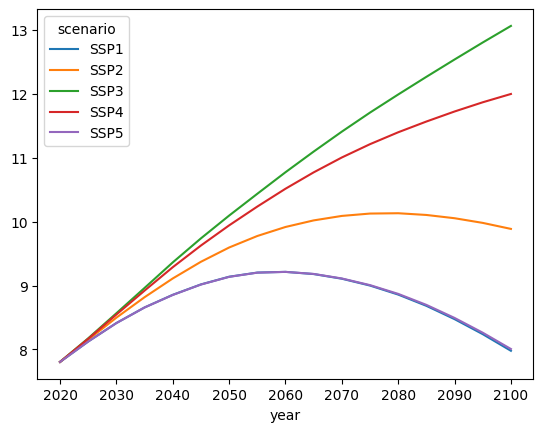

In [28]:
model = ["IIASA GDP 2023", "IIASA-WiC POP 2023"]
variable = "Population"
region = "World"
scenario = ["SSP1", "SSP2", "SSP3", "SSP4", "SSP5"]

# get the data
raw_data = conn.query(
    variable=variable,
    model=model,
    scenario=scenario,
    region=region,
)

# filter the population data and discard other columns
data = raw_data.as_pandas()
population_projected = data.loc[
    data["variable"] == variable, ["scenario", "year", "value"]
]

# convert millions to billions of people
population_projected.loc[:, "value"] = population_projected["value"].round() / 1000

# pivot the data for better plotting
population_projected_pivot = population_projected.pivot(
    columns="scenario", values="value", index="year"
)
population_projected_pivot.plot()

<Axes: xlabel='year'>

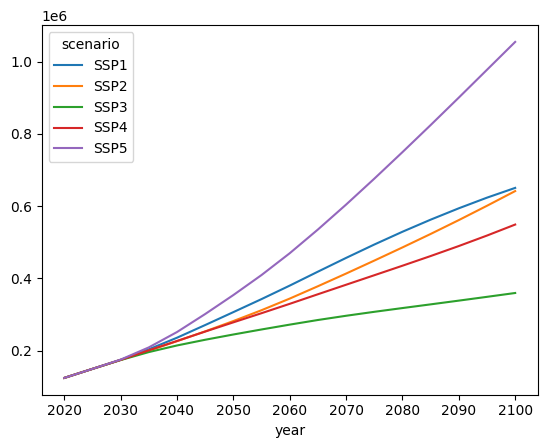

In [8]:
model = ["OECD ENV-Growth 2023"]
variable = "GDP|PPP"
region = "World"
scenario = ["SSP1", "SSP2", "SSP3", "SSP4", "SSP5"]

# get the data
raw_data = conn.query(
    variable=variable,
    model=model,
    region=region,
    scenario=scenario,
)

# filter the gdp data and discard other columns
data = raw_data.as_pandas()
gdp_projected = data.loc[data["variable"] == variable, ["scenario", "year", "value"]]

# pivot the data for better plotting
gdp_projected_pivot = gdp_projected.pivot(
    columns="scenario", values="value", index="year"
)
gdp_projected_pivot.plot()

## GHG Emissions & Global mean temperature prjections from IPCC AR6

In [9]:
connection_name = "ar6-public"
conn = pyam.iiasa.Connection(connection_name)

[INFO] 16:09:32 - pyam.iiasa: You are connected to the IXSE_AR6_PUBLIC scenario explorer hosted by IIASA. If you use this data in any published format, please cite the data as provided in the explorer guidelines: https://data.ece.iiasa.ac.at/ar6/#/about
[INFO] 16:09:32 - pyam.iiasa: You are connected as an anonymous user


In [10]:
scenario_model = {
    "SSP1-baseline": "IMAGE 3.2",
    "SSP2-Baseline": "MESSAGE-GLOBIOM 1.0",
    "SSP3-Baseline": "AIM/CGE 2.0",
    "SSP4-Baseline": "GCAM 4.2",
    "SSP5-Baseline": "WITCH-GLOBIOM 3.1",
}
region = "World"
variable = [
    "Emissions|Kyoto Gases",
    "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile",
    # "AR6 climate diagnostics|Surface Temperature (GMST)|MAGICCv7.5.3|50.0th Percentile",
]

raw_data = {}

for scenario, model in scenario_model.items():
    raw_data[scenario] = conn.query(
        variable=variable,
        model=model,
        scenario=scenario,
        region=region,
    )

In [11]:
# concatenate all dataframes
data = pd.concat([raw_data[scenario].as_pandas() for scenario in raw_data])
data

,model,scenario,region,variable,unit,year,value,version,Regional_scope,Category,...,N2O emissions reductions 2019-2030 % modelled Harmonized-Infilled,CO2 emissions reductions 2019-2100 % modelled Native,"Cumulative net CO2 (2020 to netzero, Gt CO2) (Harm-Infilled)",GHG emissions reductions 2019-2020 % modelled Native-with-Infilled,GHG emissions 2100 Gt CO2-equiv/yr (Harmonized-Infilled),CO2 emissions reductions 2019-2050 % modelled Harmonized-Infilled,GHG emissions reductions 2019-2040 % modelled Native-with-Infilled,CH4 emissions reductions 2019-2040 % modelled Harmonized-Infilled,Climate impacts,Technology_category_name
0,IMAGE 3.2,SSP1-baseline,World,AR6 climate diagnostics|Surface Temperature (G...,K,2000,0.772136,2,Global,C7,...,-3.828067,45.255905,2930.631073,-0.61315,38.570977,1.239881,-8.839892,-6.663181,NaN,NaN
1,IMAGE 3.2,SSP1-baseline,World,AR6 climate diagnostics|Surface Temperature (G...,K,2001,0.805661,2,Global,C7,...,-3.828067,45.255905,2930.631073,-0.61315,38.570977,1.239881,-8.839892,-6.663181,NaN,NaN
2,IMAGE 3.2,SSP1-baseline,World,AR6 climate diagnostics|Surface Temperature (G...,K,2002,0.827142,2,Global,C7,...,-3.828067,45.255905,2930.631073,-0.61315,38.570977,1.239881,-8.839892,-6.663181,NaN,NaN
3,IMAGE 3.2,SSP1-baseline,World,AR6 climate diagnostics|Surface Temperature (G...,K,2003,0.844294,2,Global,C7,...,-3.828067,45.255905,2930.631073,-0.61315,38.570977,1.239881,-8.839892,-6.663181,NaN,NaN
4,IMAGE 3.2,SSP1-baseline,World,AR6 climate diagnostics|Surface Temperature (G...,K,2004,0.857237,2,Global,C7,...,-3.828067,45.255905,2930.631073,-0.61315,38.570977,1.239881,-8.839892,-6.663181,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,WITCH-GLOBIOM 3.1,SSP5-Baseline,World,Emissions|Kyoto Gases,Mt CO2-equiv/yr,2060,123902.883039,2,Global,C8,...,-11.845971,-163.986773,7545.920087,-2.94025,147.703764,-102.746283,-64.237751,-42.907785,no,NaN
108,WITCH-GLOBIOM 3.1,SSP5-Baseline,World,Emissions|Kyoto Gases,Mt CO2-equiv/yr,2070,134627.240322,2,Global,C8,...,-11.845971,-163.986773,7545.920087,-2.94025,147.703764,-102.746283,-64.237751,-42.907785,no,NaN
109,WITCH-GLOBIOM 3.1,SSP5-Baseline,World,Emissions|Kyoto Gases,Mt CO2-equiv/yr,2080,142976.721181,2,Global,C8,...,-11.845971,-163.986773,7545.920087,-2.94025,147.703764,-102.746283,-64.237751,-42.907785,no,NaN
110,WITCH-GLOBIOM 3.1,SSP5-Baseline,World,Emissions|Kyoto Gases,Mt CO2-equiv/yr,2090,146605.361850,2,Global,C8,...,-11.845971,-163.986773,7545.920087,-2.94025,147.703764,-102.746283,-64.237751,-42.907785,no,NaN


<Axes: xlabel='year'>

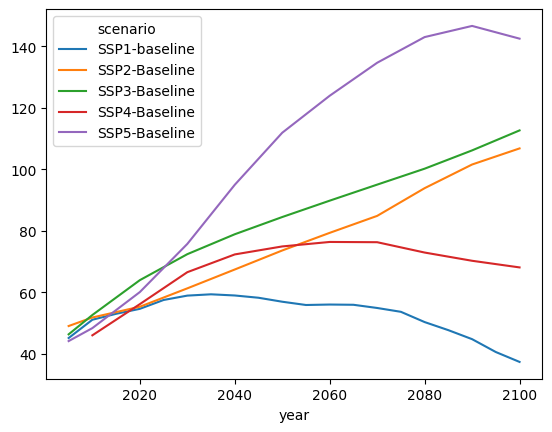

In [12]:
ghgem_projected = data.loc[
    data["variable"] == "Emissions|Kyoto Gases", ["scenario", "year", "value"]
]
# convert M tonnes to G tonnes CO2
ghgem_projected.loc[:, "value"] = ghgem_projected["value"] / 1000
ghgem_projected_pivot = ghgem_projected.pivot(
    columns="scenario", values="value", index="year"
)
ghgem_projected_pivot = ghgem_projected_pivot.interpolate(method="linear")
ghgem_projected_pivot.plot()

<Axes: xlabel='year'>

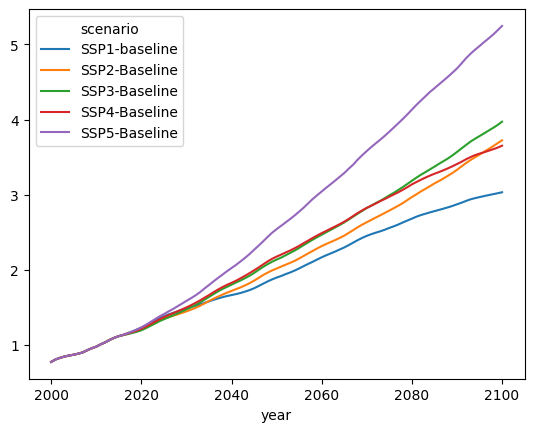

In [13]:
temperature_projected = data.loc[
    data["variable"]
    == "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile",
    ["scenario", "year", "value"],
]
temperature_projected_pivot = temperature_projected.pivot(
    columns="scenario", values="value", index="year"
)
temperature_projected_pivot.plot()

## Historical Population, GDP, Temperature & GHG emissions from OurWorldInData

In [14]:
# ~14MB of data
data_url = "https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv"
response = requests.get(data_url)
raw_data = pd.read_csv(
    io.BytesIO(response.content),
    index_col=False,
    header=0,
)

In [15]:
data = raw_data.loc[
    raw_data["country"] == "World",
    [
        "year",
        "population",
        "gdp",
        "total_ghg",
        "temperature_change_from_ghg",
    ],
]
data = data.set_index("year")
data

,population,gdp,total_ghg,temperature_change_from_ghg
year,,,,
1750,7.532793e+08,NaN,NaN,NaN
1751,NaN,NaN,NaN,NaN
1752,NaN,NaN,NaN,NaN
1753,NaN,NaN,NaN,NaN
1754,NaN,NaN,NaN,NaN
...,...,...,...,...
2019,7.811294e+09,1.221494e+14,52796.523,1.571
2020,7.887001e+09,1.185900e+14,50792.543,1.595
2021,7.954448e+09,1.260048e+14,52938.793,1.619


<Axes: xlabel='year'>

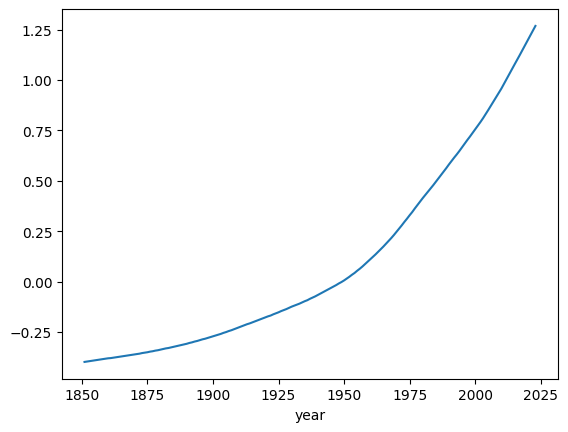

In [16]:
temperature_historical = data.loc[:, "temperature_change_from_ghg"].copy()
temperature_historical.name = "Historical Reference"
temperature_historical = temperature_historical.dropna(how="all")
# ssp temperature delta is referred to 1850-1900 average, so substract 0.4 to match them
temperature_historical -= 0.4
temperature_historical.plot()

<Axes: xlabel='year'>

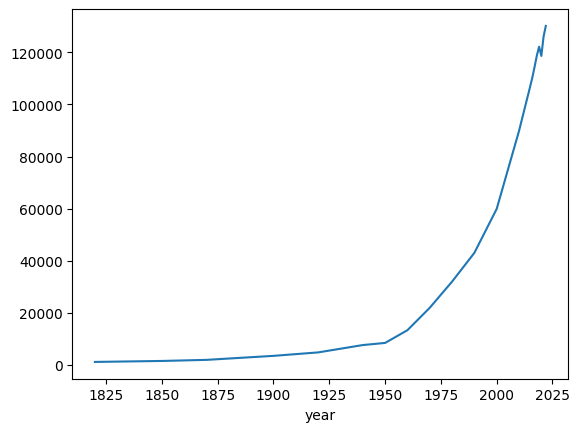

In [17]:
gdp_historical = data.loc[:, "gdp"].copy()
gdp_historical /= 1e9  # convert to billion USD
gdp_historical.name = "Historical Reference"
gdp_historical = gdp_historical.dropna(how="all")
gdp_historical.plot()

<Axes: xlabel='year'>

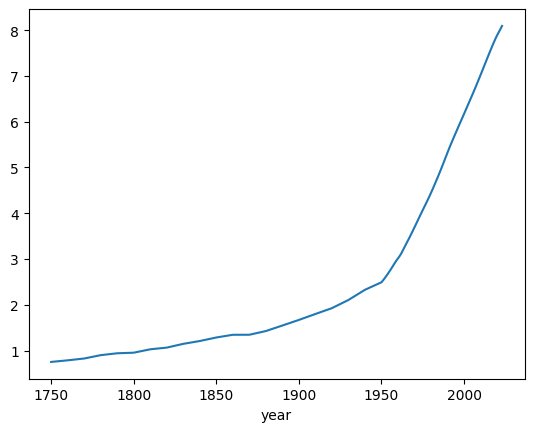

In [18]:
population_historical = data.loc[:, "population"].copy()
population_historical /= 1e9  # convert to billions of people
population_historical.name = "Historical Reference"
population_historical = population_historical.dropna(how="all")
population_historical.plot()

<Axes: xlabel='year'>

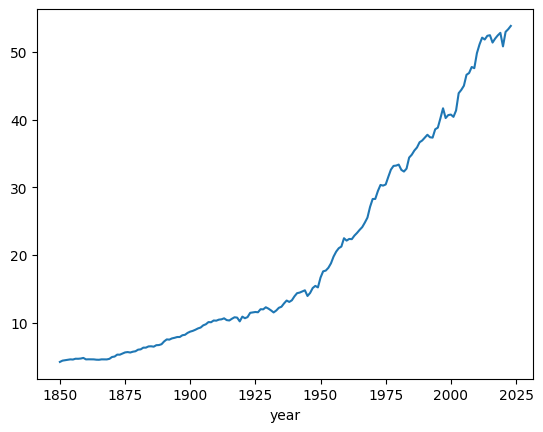

In [19]:
ghgem_historical = data.loc[:, "total_ghg"].copy()
ghgem_historical /= 1e3  # convert MtCO2 to GtCO2
ghgem_historical.name = "Historical Reference"
ghgem_historical = ghgem_historical.dropna(how="all")
ghgem_historical.plot()

## Merge historical with projected data

<Axes: xlabel='year'>

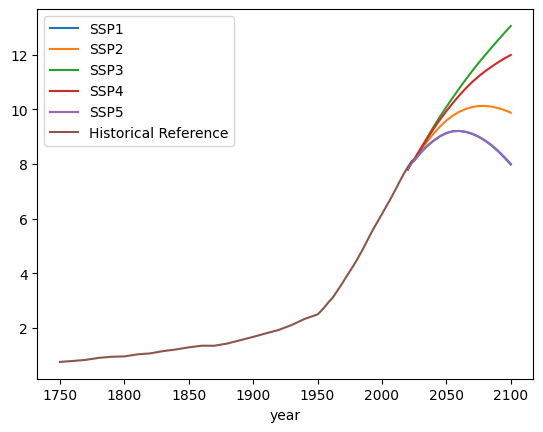

In [31]:
population_pivot = (
    population_projected_pivot.loc[ssp_start_year:]
    .join(
        population_historical,
        how="outer",
    )
    .interpolate(
        method="linear",
        limit_area="inside",
    )
)
population_pivot.plot()

<Axes: xlabel='year'>

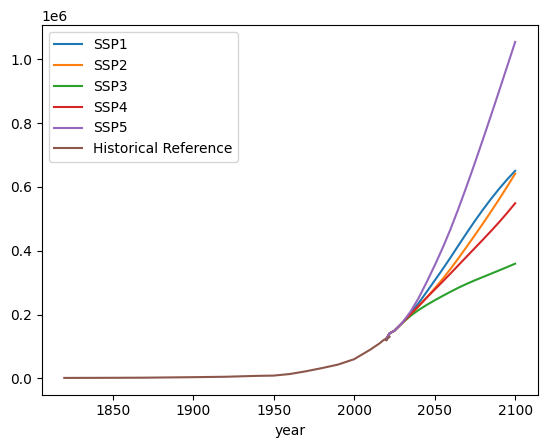

In [32]:
gdp_pivot = (
    gdp_projected_pivot.loc[ssp_start_year:]
    .join(
        gdp_historical,
        how="outer",
    )
    .interpolate(
        method="linear",
        limit_area="inside",
    )
)
gdp_pivot.plot()

<Axes: xlabel='year'>

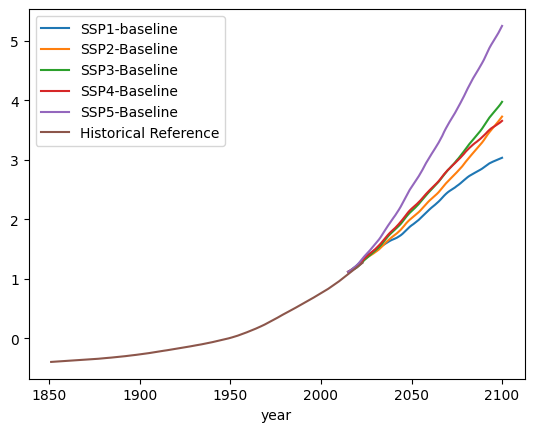

In [34]:
temperature_pivot = (
    temperature_projected_pivot.loc[ssp_start_year:]
    .join(
        temperature_historical,
        how="outer",
    )
    .interpolate(
        method="linear",
        limit_area="inside",
    )
)
temperature_pivot.plot()

<Axes: xlabel='year'>

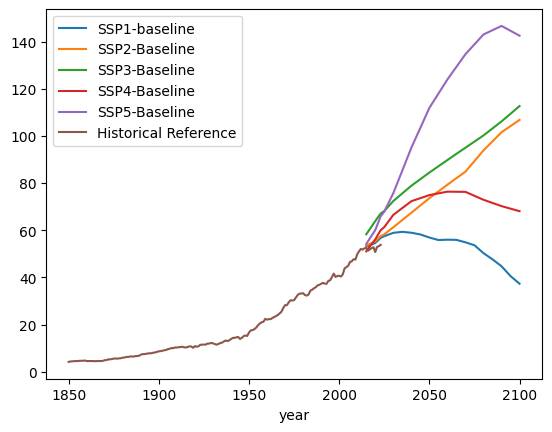

In [35]:
ghgem_pivot = (
    ghgem_projected_pivot.loc[ssp_start_year:]
    .join(
        ghgem_historical,
        how="outer",
    )
    .interpolate(
        method="linear",
        limit_area="inside",
    )
)
ghgem_pivot.plot()

## Improve the plots for the presentation

In [37]:
ROOT_FOLDER = Path().resolve()

images_dir = Path(ROOT_FOLDER / "output" / "images" / "ssp")
images_dir.mkdir(parents=True, exist_ok=True)

load_font()
plt.style.use("default")
set_plot_style()

In [38]:
column_conversion = {
    "SSP1": "Sviluppo sostenibile",
    "SSP2": "Metà strada",
    "SSP3": "Rivalità regionali",
    "SSP4": "Diseguaglianza",
    "SSP5": "Sviluppo basato sui combustibili fossili",
    "Historical Reference": "Storico",
    "SSP1-baseline": "Sviluppo sostenibile",
    "SSP2-Baseline": "Metà strada",
    "SSP3-Baseline": "Rivalità regionali",
    "SSP4-Baseline": "Diseguaglianza",
    "SSP5-Baseline": "Sviluppo basato sui combustibili fossili",
}

In [39]:
co2 = ghgem_pivot.rename(columns=column_conversion)
pil = gdp_pivot.rename(columns=column_conversion)
population = population_pivot.rename(columns=column_conversion)
temperature = temperature_pivot.rename(columns=column_conversion)

In [40]:
co2.index = co2.index.astype(int)
pil.index = pil.index.astype(int)
population.index = population.index.astype(int)
temperature.index = temperature.index.astype(int)

In [41]:
# Move "Storico" column to the end for all dataframes
for df in [co2, pil, population, temperature]:
    if "Storico" in df.columns:
        storico = df.pop("Storico")
        df["Storico"] = storico

In [42]:
xy_labels = {
    "co2": {
        "Sviluppo sostenibile": (2040, 5),
        "Metà strada": (2055, 25),
        "Rivalità regionali": (2055, 80),
        "Diseguaglianza": (2070, 40),
        "Sviluppo basato sui combustibili fossili": (2012, 88),
        "Storico": (2000, 30),
    },
    "pil": {
        "Sviluppo sostenibile": (2055, 465),
        "Metà strada": (2075, 410),
        "Rivalità regionali": (2045, 150),
        "Diseguaglianza": (2055, 250),
        "Sviluppo basato sui combustibili fossili": (2035, 600),
        "Storico": (1990, 100),
    },
    "population": {
        "Sviluppo sostenibile": (2055, 7),
        "Metà strada": (2055, 9),
        "Rivalità regionali": (2045, 11.7),
        "Diseguaglianza": (2055, 9.8),
        "Sviluppo basato sui combustibili fossili": (2075, 8.1),
        "Storico": (1960, 5),
    },
    "temperature": {
        "Sviluppo sostenibile": (2028, 2),
        "Metà strada": (2055, 9),
        "Rivalità regionali": (2050, 11.7),
        "Diseguaglianza": (2055, 9.8),
        "Sviluppo basato sui combustibili fossili": (2000, 3.1),
        "Storico": (1900, 0.7),
    },
}

rotation_labels = {
    "co2": {
        "Sviluppo sostenibile": -30,
        "Metà strada": -30,
        "Rivalità regionali": 20,
        "Diseguaglianza": -30,
        "Sviluppo basato sui combustibili fossili": 53,
        "Storico": 25,
    },
    "pil": {
        "Sviluppo sostenibile": 37,
        "Metà strada": 40,
        "Rivalità regionali": 10,
        "Diseguaglianza": 15,
        "Sviluppo basato sui combustibili fossili": 57,
        "Storico": 0,
    },
    "population": {
        "Sviluppo sostenibile": -45,
        "Metà strada": 0,
        "Rivalità regionali": 50,
        "Diseguaglianza": 1,
        "Sviluppo basato sui combustibili fossili": -40,
        "Storico": 55,
    },
    "temperature": {
        "Sviluppo sostenibile": 45,
        "Metà strada": 0,
        "Rivalità regionali": 40,
        "Diseguaglianza": 0,
        "Sviluppo basato sui combustibili fossili": 65,
        "Storico": 0,
    },
}

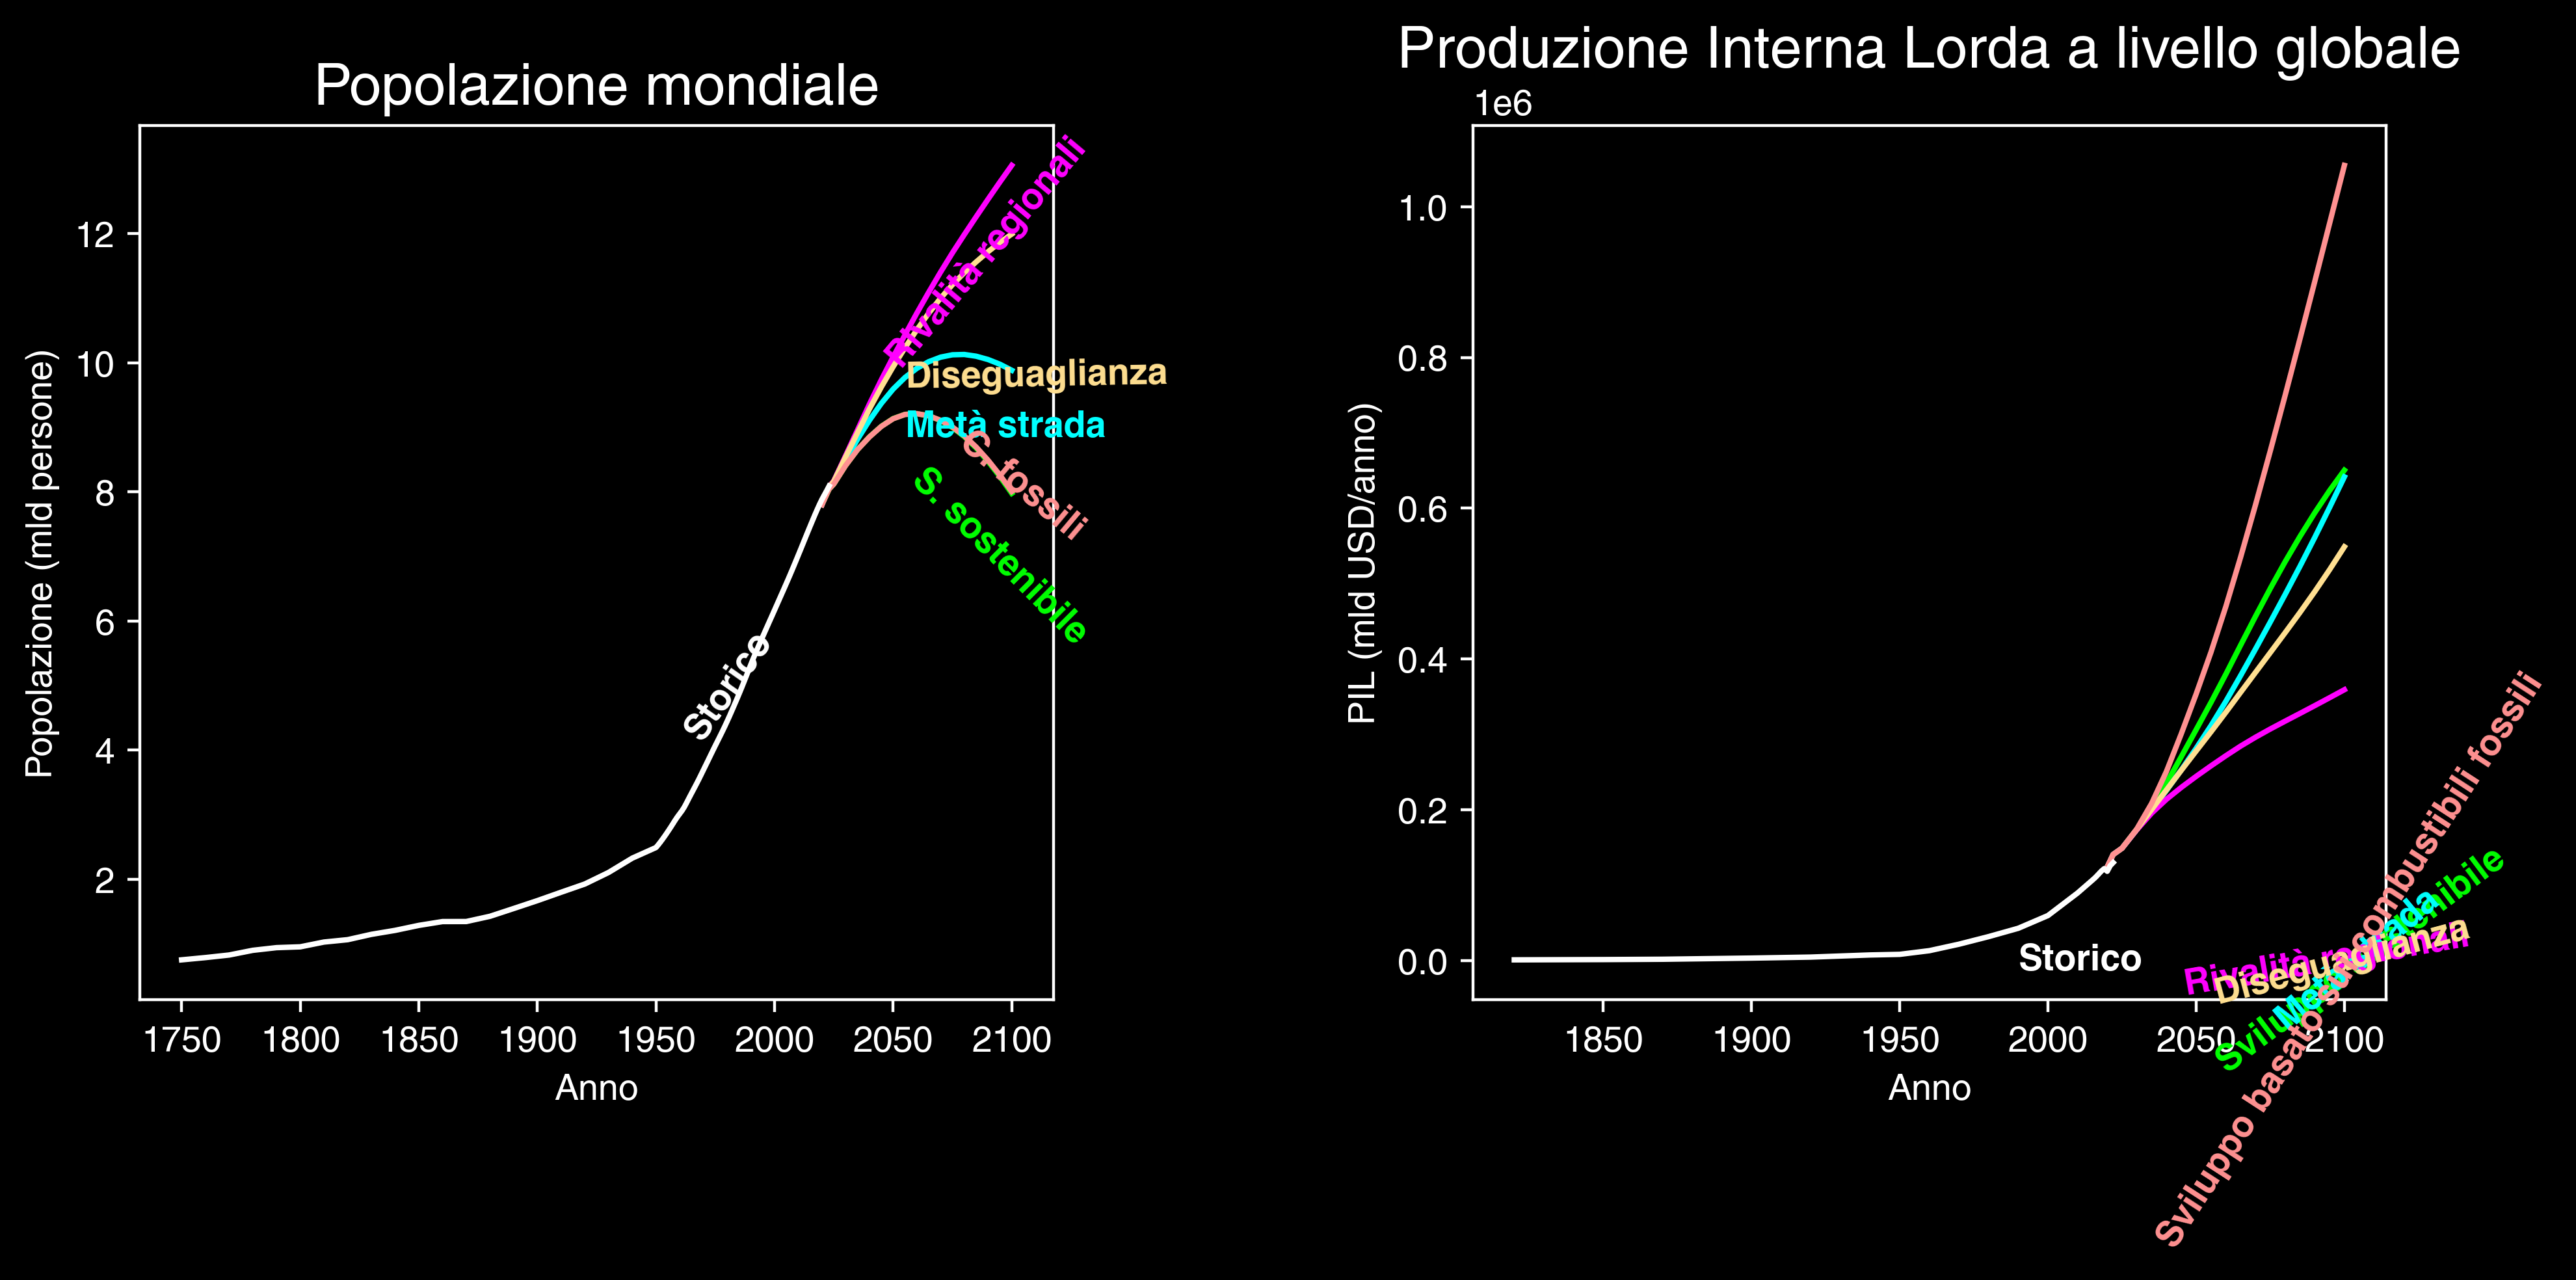

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

custom_labels = {
    "Sviluppo sostenibile": "S. sostenibile",
    "Sviluppo basato sui combustibili fossili": "C. fossili",
}

lines = population.plot(ax=axs[0], legend=False, color=colors).get_lines()
for line, column in zip(lines, population.columns):
    axs[0].annotate(
        custom_labels.get(column, column),
        xy=xy_labels["population"][column],
        va="center",
        color=line.get_color(),  # Use same color as the line
        weight="bold",
        rotation=rotation_labels["population"][column],
    )
axs[0].set_title("Popolazione mondiale")
axs[0].set_xlabel("Anno")
axs[0].set_ylabel("Popolazione (mld persone)")

lines = pil.plot(ax=axs[1], legend=False, color=colors).get_lines()
for line, column in zip(lines, pil.columns):
    axs[1].annotate(
        column,
        xy=xy_labels["pil"][column],
        va="center",
        color=line.get_color(),  # Use same color as the line
        weight="bold",
        rotation=rotation_labels["pil"][column],
    )
axs[1].set_title("Produzione Interna Lorda a livello globale")
axs[1].set_xlabel("Anno")
axs[1].set_ylabel("PIL (mld USD/anno)")

plt.tight_layout(w_pad=5)  # Add horizontal spacing between subplots

plt.show()
fig.savefig(images_dir / "population_pil.svg")

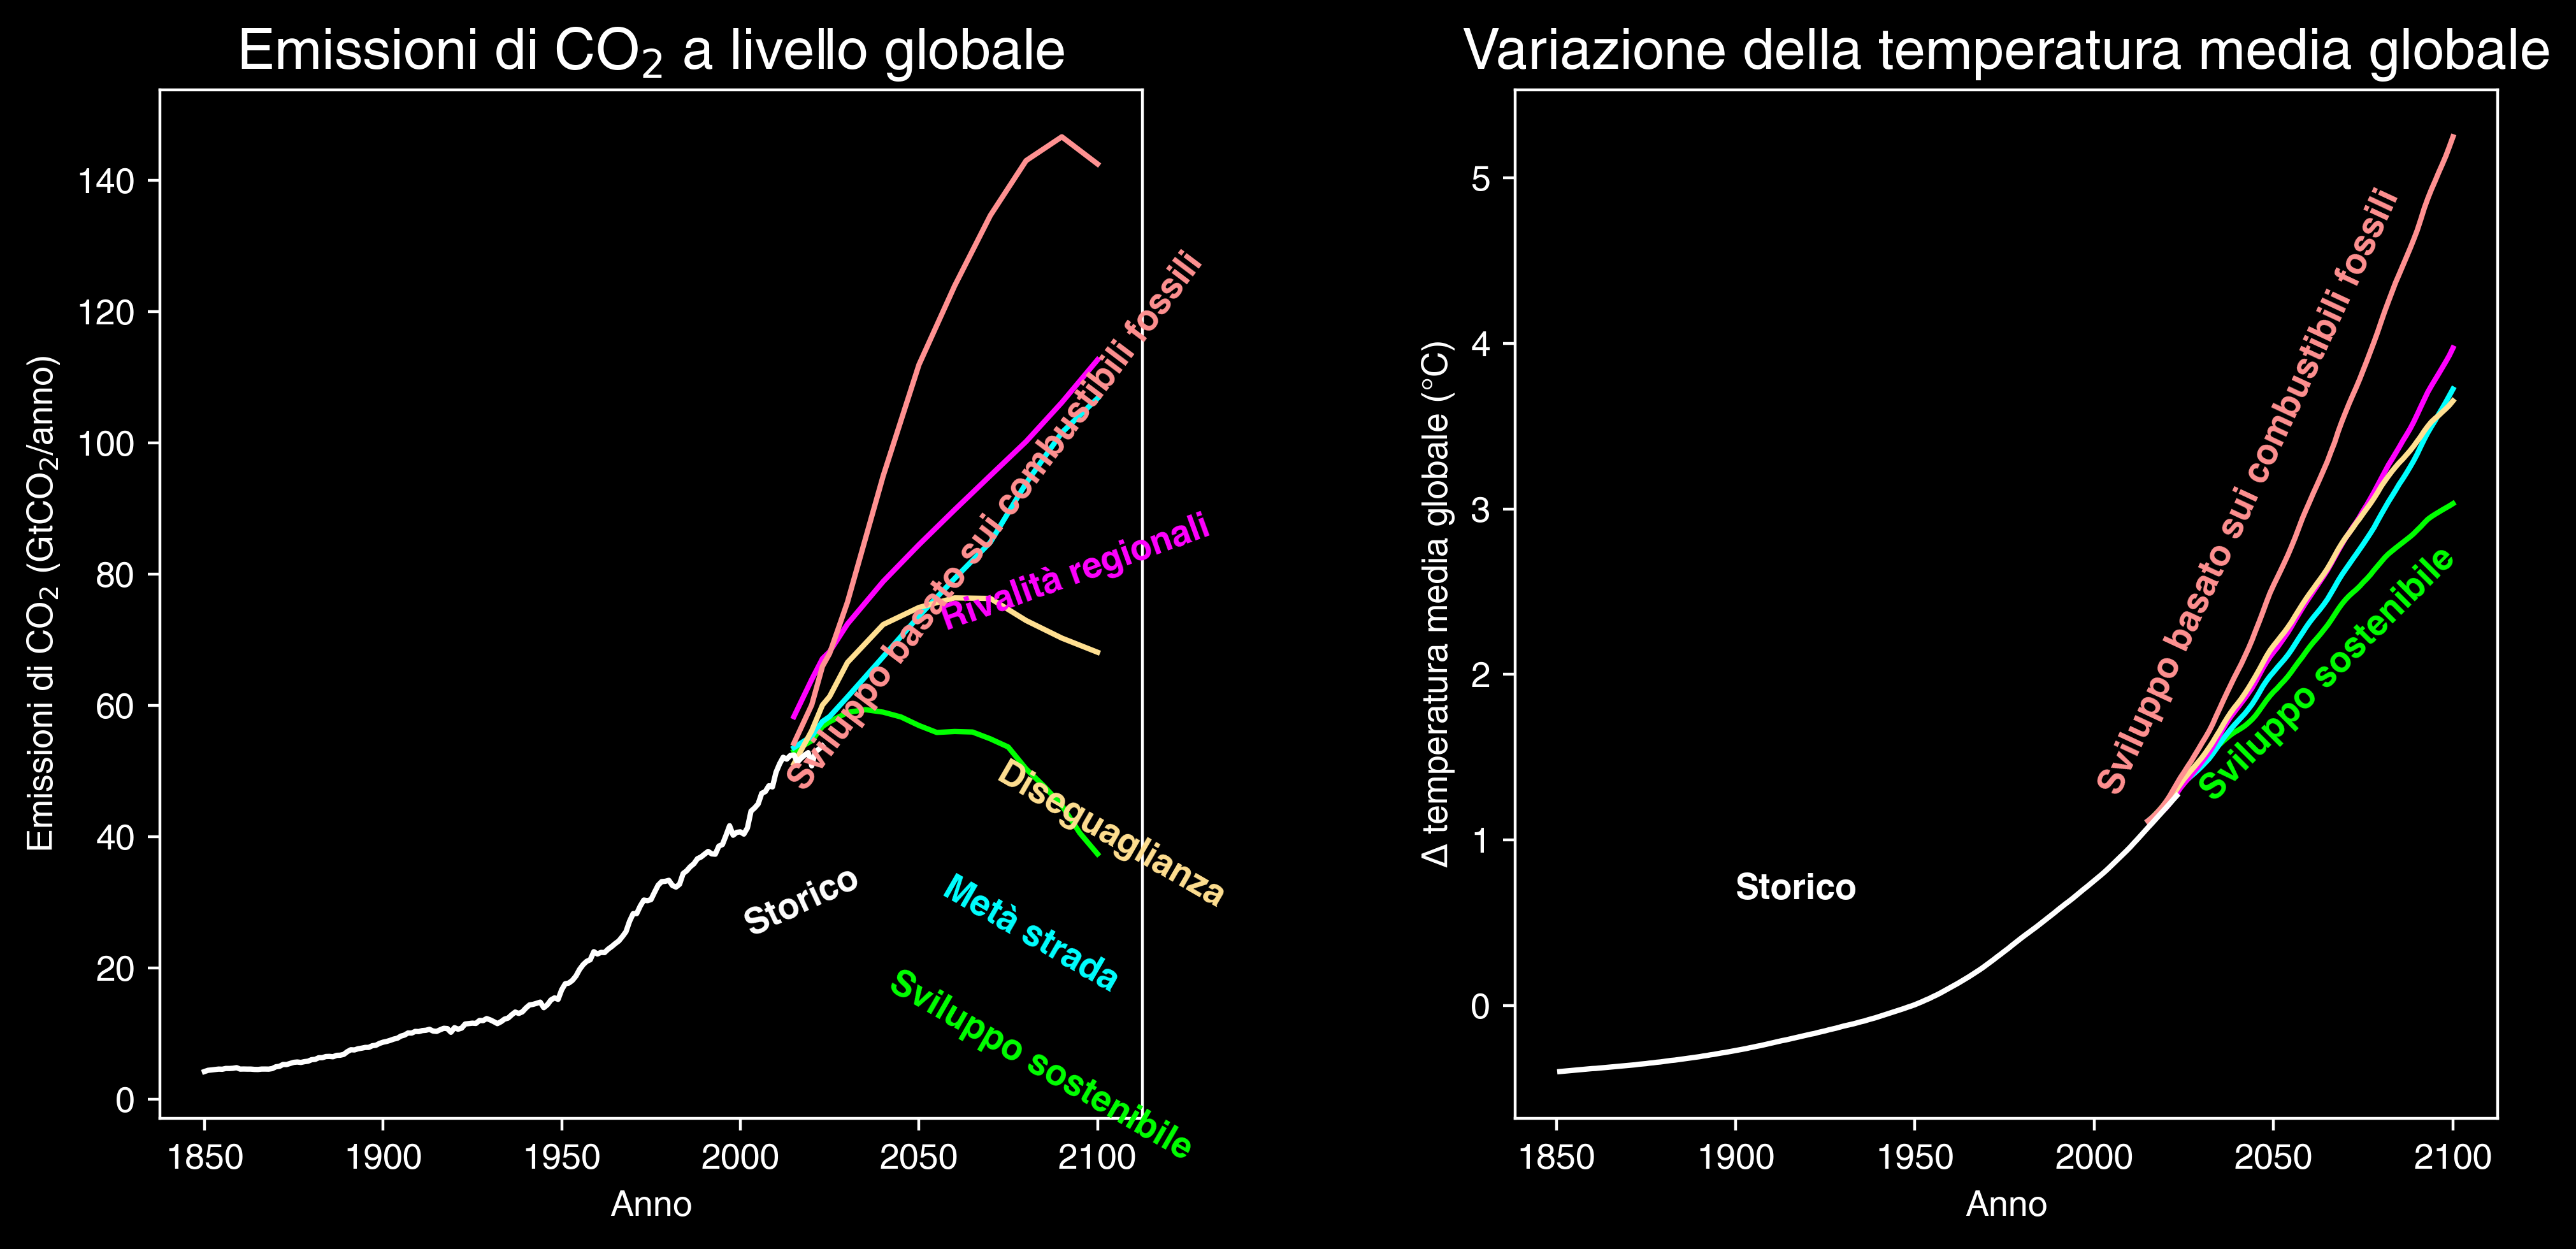

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


lines = co2.plot(ax=axs[0], legend=False, color=colors.values()).get_lines()
for line, column in zip(lines, co2.columns):
    # Add label at the end of each line with matching color
    axs[0].annotate(
        column,
        xy=xy_labels["co2"][column],
        va="center",
        color=line.get_color(),  # Use same color as the line
        weight="bold",
        rotation=rotation_labels["co2"][column],
    )
axs[0].set_title("Emissioni di CO$_2$ a livello globale")
axs[0].set_xlabel("Anno")
axs[0].set_ylabel("Emissioni di CO$_2$ (GtCO$_2$/anno)")

lines = temperature.plot(ax=axs[1], legend=False, color=colors.values()).get_lines()
for line, column in zip(lines, temperature.columns):
    axs[1].annotate(
        column,
        xy=xy_labels["temperature"][column],
        va="center",
        color=line.get_color(),  # Use same color as the line
        weight="bold",
        rotation=rotation_labels["temperature"][column],
    )
axs[1].set_title("Variazione della temperatura media globale")
axs[1].set_xlabel("Anno")
axs[1].set_ylabel(r"$\Delta$ temperatura media globale (°C)")

plt.tight_layout(w_pad=5)  # Add horizontal spacing between subplots

plt.show()
fig.savefig(images_dir / "co2_temperature.svg")